## Problema 2

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from sklearn.linear_model import LinearRegression as LR
import functools

In [11]:
X_simple,t_simple = simple_dataset(noise=5,n_samples=300)

## feature normalisation

# X_simple = X_simple / X_simple.max()

division_ratio = 0.8
split_point =int(division_ratio * len(X_simple)) 

X_train_simple = X_simple[:split_point]
X_test_simple = X_simple[split_point:]

t_train_simple = t_simple[:split_point]
t_test_simple = t_simple[split_point:]

print(type(X_simple))

<class 'numpy.ndarray'>


### Ridge regression

#### Matricea aia e inversabila | poti si forma completa si forma cu gradient descent

In [12]:
def shuffle_data(X,t,shuffle=True):
    '''
    X - N x d
    t - N x _
    '''
    data = np.hstack((X,t[:,np.newaxis]))
    if shuffle:
        np.random.shuffle(data)
    new_X = data[:,:-1]
    new_t = data[:,-1]

    return new_X,new_t

In [13]:
class RidgeRegression():

    def __init__(self,alpha=1):
        self.alpha = alpha

    def fit(self, X, t):

        N, D = X.shape
        X_t = np.transpose(X)
        self.w = np.linalg.inv(X.T @ X + self.alpha * np.identity(X.shape[1])) @ X.T @ t

    def predict(self, X, return_std=False):

        N, D = X.shape

        y = X @ self.w
        # print(X.shape,y.shape,"IN predict")
        
        if return_std:

            y_std = np.sqrt(self.var) 

            return y, y_std
        return y

In [14]:
class LinearRegression(object):

    def __init__(self, learning_rate=0.01, epochs=300, eps=1e-6,alpha=0.0001):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.eps = eps
        self.alpha = alpha
        ## [(epoch,error)]
        self.errors = []

    def fit(self, X, t):

        N, D = X.shape
        
        self.w = np.zeros(D)
        prev_w = self.w 
        prev_cost = self.cost(X,t)

        for ep in range(self.epochs):
            g = self.gradient(X,t)
            step = self.learning_rate * g
            self.w = self.w - step
            
            prev_cost = self.cost(X,t)

            self.errors += [(ep,prev_cost)]

            if np.linalg.norm(self.w - prev_w) < self.eps:
               
                break

            prev_w = self.w



        # return self

    def predict(self, X, return_std=False):
        N, D = X.shape
        y = X @ self.w 
        return y

    
    ## Not 1 / n 
    def cost(self,X,t,return_std=False):
        y = self.predict(X,return_std)
        loss = (y - t) ** 2
        # return 0.5 * loss
        return np.mean(loss)

    def gradient(self,X,t):
        y = self.predict(X)
        d_bias =  -2*sum(t - y)
        d_w = -2*sum(X[:,1:] * (t - y).reshape(-1,1))
        g = np.append(np.array(d_bias), d_w) 
        return g / X.shape[0] + self.alpha * self.w
        # return g / 2 

In [15]:
def mean_squared_error(y, t):
    return np.mean((y - t) * (y- t))

def normalised_squared_error(y,t):
    return np.mean((y - t) / t.max()  * (y- t) / t.max())

def RMSE(y,t):
    return np.sqrt(mean_squared_error(y,t))

def NRMSE(y,t):
    return RMSE(y,t) / (np.max(t) - np.min(t))

In [16]:
def extract_polynomial_features(X, M):
    phi = X
    return np.array([x ** np.arange(M + 1) for x in phi])

In [17]:
def ten_fold_validation(X,t,model,shuffle=False):
    
    new_X,new_t = shuffle_data(X,t,shuffle=shuffle)
    data = np.hstack((new_X,new_t[:,np.newaxis]))
    splitted_data = np.split(data,10)
    errors = []

    for i in range(10):
        ## i is the test set 
        X_test = splitted_data[i][:,:-1]
        t_test = splitted_data[i][:,-1]

        not_init = True
        train_data = None
        for j in range(10):
            if j != i:
                if not_init:
                    train_data = splitted_data[j]
                    not_init = False
                else:
                    train_data = np.vstack((train_data,splitted_data[j]))

        
        X_train = train_data[:,:-1]
        t_train = train_data[:,-1]

        X_train_feat = extract_polynomial_features(X_train,1)
        X_test_feat = extract_polynomial_features(X_test,1)

        model.fit(X_train_feat,t_train)
        y = model.predict(X_test_feat)
        errors += [mean_squared_error(y,t_test)]
        

    return errors



Mean MSE: 26.91087422609351


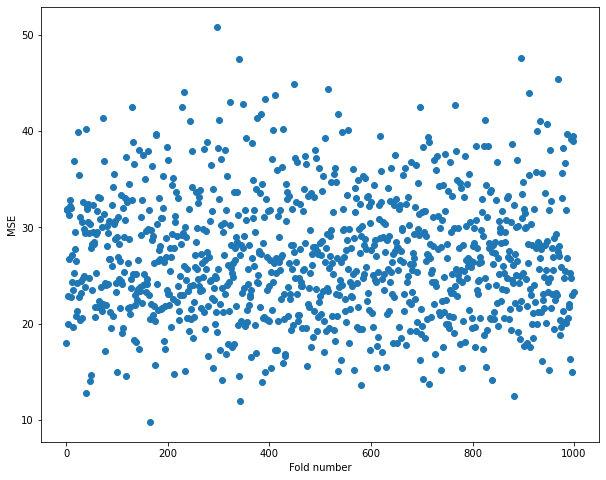

In [26]:
errors = []
mean_errors = []
for i in range(100):
    errors += ten_fold_validation(X_simple,t_simple,RidgeRegression(),shuffle=True)



print("Mean MSE:",np.mean(errors))
fig = plt.figure(figsize=(10, 8))
plt.xlabel("Fold number")
plt.ylabel("MSE")
plt.scatter([i for i in range(1000)],errors)
plt.show()



The alpha that yields the minimum MSE for the most times is: 0.2583333333333333


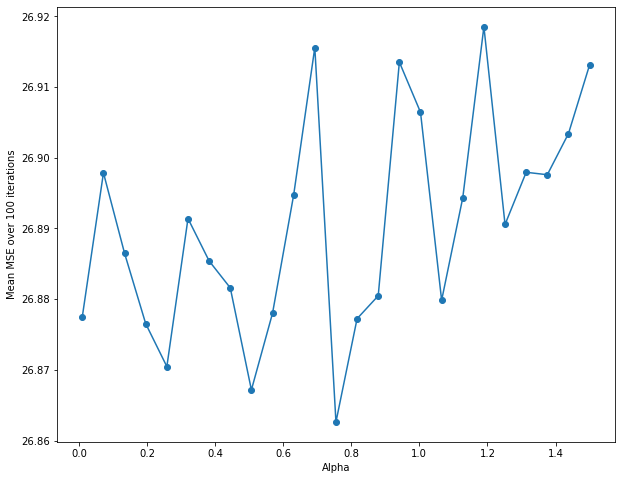

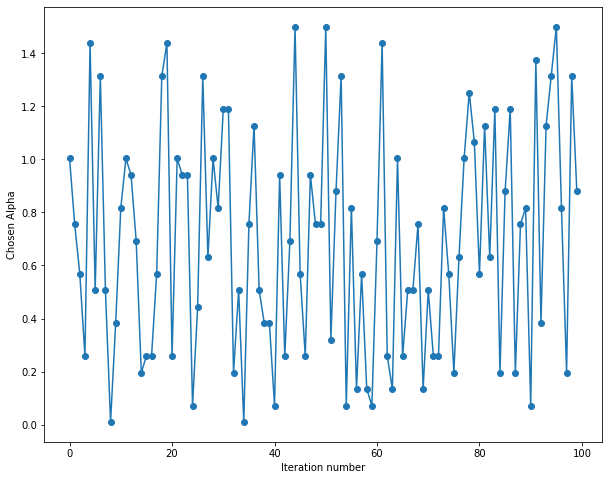

In [37]:
VERBOSE = False


alphas = np.linspace(0.01,1.5,25)
chosen_alphas = {}
error_alphas = {}
alphas_per_iteration = []

for alpha in alphas:
    chosen_alphas[alpha] = 0
    error_alphas[alpha] = []

for i in range(100):
    min_error = 1e6
    winner_alpha = 1e6
    for alpha in alphas:
        model = RidgeRegression(alpha=alpha)
        err = np.mean(ten_fold_validation(X_simple,t_simple,model,shuffle=True))
        error_alphas[alpha] += [err]

        # print("Alpha:",alpha," Mean error:",err)

        if err < min_error:
            min_error = err
            winner_alpha = alpha

    chosen_alphas[winner_alpha] += 1
    alphas_per_iteration += [(i,winner_alpha)]

if VERBOSE:
    print(chosen_alphas)
    
    for key,val in error_alphas.items():
        print("Alpha:",key," Mean error:",np.mean(val))
    
best_alpha = max(chosen_alphas,key=chosen_alphas.get)

print("The alpha that yields the minimum MSE for the most times is:",best_alpha)

fig = plt.figure(figsize=(10, 8))
plt.xlabel("Alpha")
plt.ylabel("Mean MSE over 100 iterations")
plt.scatter(error_alphas.keys(),list(map(np.mean,error_alphas.values())))
plt.plot(error_alphas.keys(),list(map(np.mean,error_alphas.values())))
plt.show()

fig = plt.figure(figsize=(10, 8))
plt.xlabel("Iteration number")
plt.ylabel("Chosen Alpha")
plt.scatter([x[0] for x in alphas_per_iteration],[x[1] for x in alphas_per_iteration])
plt.plot([x[0] for x in alphas_per_iteration],[x[1] for x in alphas_per_iteration])
plt.show()


### Observatie : Alpha cu cel mai mic Mean MSE peste 100 iteratii nu este neaparat alpha ales de cele mai multe ori ca avand MSE optim

Findca am ales sa implementez regresie liniara cu regularizare in forma completa am nevoie de o regularizare mai mare care se aplica la final, pentru ca nu exista epoci de iteratie sa se faca regularizare incremental la fiecare epoca.

Am testat procedura de mai sus si cu un model LR cu regularizare forma gradient descent, iar acolo alpha optim este mult mai mic decat in acest caz ( sub 0.000001 ).

Deci am ales un interval intre 0.01 si 1 pentru ca vreau o regularizare mai mare care se aplica la final.